## Usage
- Update the configuration cell with your COCO JSON and image directory paths.
- Run the loader cell to register the COCO dataset and load samples.
- Use the interactive viewer to step through each augmented image with overlayed category masks.
- Render the grid cell for a quick collage of random samples.

In [1]:
%matplotlib inline

from pathlib import Path
import random
import sys
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2

try:
    import ipywidgets as widgets
except Exception:
    widgets = None

from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import ColorMode, Visualizer

plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 120


In [5]:
# --- Configure these paths before running the rest of the notebook ---
COCO_JSON_PATH = Path("/mnt/data/mis2025/group_6/Data/hBN/diffusion_data/_annotations_rle_tape.coco.json")
IMAGE_ROOT = Path("/mnt/data/mis2025/group_6/Data/hBN/diffusion_data")

SAMPLE_LIMIT = 24  # Set to None to use every sample
RANDOM_SEED = 42
DISPLAY_COLUMNS = 2


In [6]:
if not COCO_JSON_PATH.exists():
    raise FileNotFoundError(f"COCO file not found: {COCO_JSON_PATH}")
if not IMAGE_ROOT.exists():
    raise FileNotFoundError(f"Image root not found: {IMAGE_ROOT}")

# Register the dataset with a unique name to avoid conflicts if run multiple times
dataset_name = f"coco_viz_{random.randint(0, 100000)}"
register_coco_instances(dataset_name, {}, str(COCO_JSON_PATH), str(IMAGE_ROOT))

metadata = MetadataCatalog.get(dataset_name)
dataset_dicts = DatasetCatalog.get(dataset_name)

if SAMPLE_LIMIT is not None:
    random.seed(RANDOM_SEED)
    samples = random.sample(dataset_dicts, min(SAMPLE_LIMIT, len(dataset_dicts)))
else:
    samples = dataset_dicts

print(
    f"Loaded {len(samples)} samples from {dataset_name}."
    f"Classes: {metadata.thing_classes}"
)


Loaded 24 samples from coco_viz_59058.Classes: ['flakes']


In [7]:
def render_sample(dataset_dict, ax=None):
    img = cv2.imread(dataset_dict["file_name"])
    if img is None:
        print(f"[WARN] Missing image file: {dataset_dict['file_name']}")
        img = np.zeros((dataset_dict["height"], dataset_dict["width"], 3), dtype=np.uint8)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    vis = Visualizer(
        img,
        metadata=metadata,
        scale=1.0,
        instance_mode=ColorMode.IMAGE,
    )
    vis = vis.draw_dataset_dict(dataset_dict)

    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
        created_fig = True
    ax.imshow(vis.get_image())
    ax.set_title(Path(dataset_dict["file_name"]).name)
    ax.axis("off")
    if created_fig:
        plt.show()
    return ax


def preview_sample(index: int) -> None:
    if not samples:
        raise RuntimeError("No samples loaded; run the loader cell first")
    index = max(0, min(index, len(samples) - 1))
    sample = samples[index]
    print(f"Sample {index + 1}/{len(samples)} | {sample['file_name']}")
    render_sample(sample)


In [ ]:
if widgets and len(samples) > 1:
    _slider = widgets.IntSlider(min=0, max=len(samples) - 1, step=1, description="index")
    widgets.interact(preview_sample, index=_slider)
else:
    preview_sample(0)

interactive(children=(IntSlider(value=0, description='index', max=23), Output()), _dom_classes=('widget-intera…

[ WARN:0@767.186] global loadsave.cpp:241 findDecoder imread_('/mnt/data/mis2025/group_6/Data/hBN/diffusion_data/-5_png_jpg.rf.b4fcffee63a95557acf6fc2daf4b10e5.jpg'): can't open/read file: check file path/integrity
[ WARN:0@767.292] global loadsave.cpp:241 findDecoder imread_('/mnt/data/mis2025/group_6/Data/hBN/diffusion_data/4_1_1_png.rf.dbd4ed36d788d5497f3657d2c059893d.jpg'): can't open/read file: check file path/integrity


[WARN] Missing image file: /mnt/data/mis2025/group_6/Data/hBN/diffusion_data/-5_png_jpg.rf.b4fcffee63a95557acf6fc2daf4b10e5.jpg
[WARN] Missing image file: /mnt/data/mis2025/group_6/Data/hBN/diffusion_data/4_1_1_png.rf.dbd4ed36d788d5497f3657d2c059893d.jpg
[WARN] Missing image file: /mnt/data/mis2025/group_6/Data/hBN/diffusion_data/thin7-50x_png.rf.c44ba01bb769eb4dbf2213a895cdab54.jpg
[WARN] Missing image file: /mnt/data/mis2025/group_6/Data/hBN/diffusion_data/-7-11_1_1_png.rf.0a1fa665d9083ca7d259a83e7ae35b4d.jpg


[ WARN:0@767.563] global loadsave.cpp:241 findDecoder imread_('/mnt/data/mis2025/group_6/Data/hBN/diffusion_data/thin7-50x_png.rf.c44ba01bb769eb4dbf2213a895cdab54.jpg'): can't open/read file: check file path/integrity
[ WARN:0@767.733] global loadsave.cpp:241 findDecoder imread_('/mnt/data/mis2025/group_6/Data/hBN/diffusion_data/-7-11_1_1_png.rf.0a1fa665d9083ca7d259a83e7ae35b4d.jpg'): can't open/read file: check file path/integrity


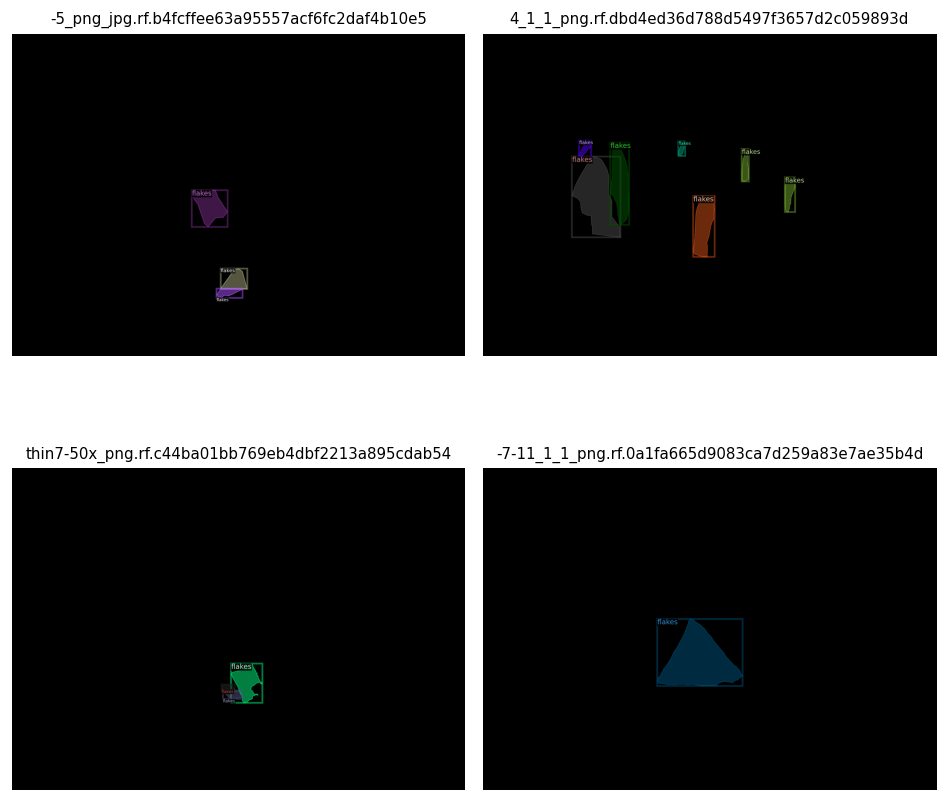

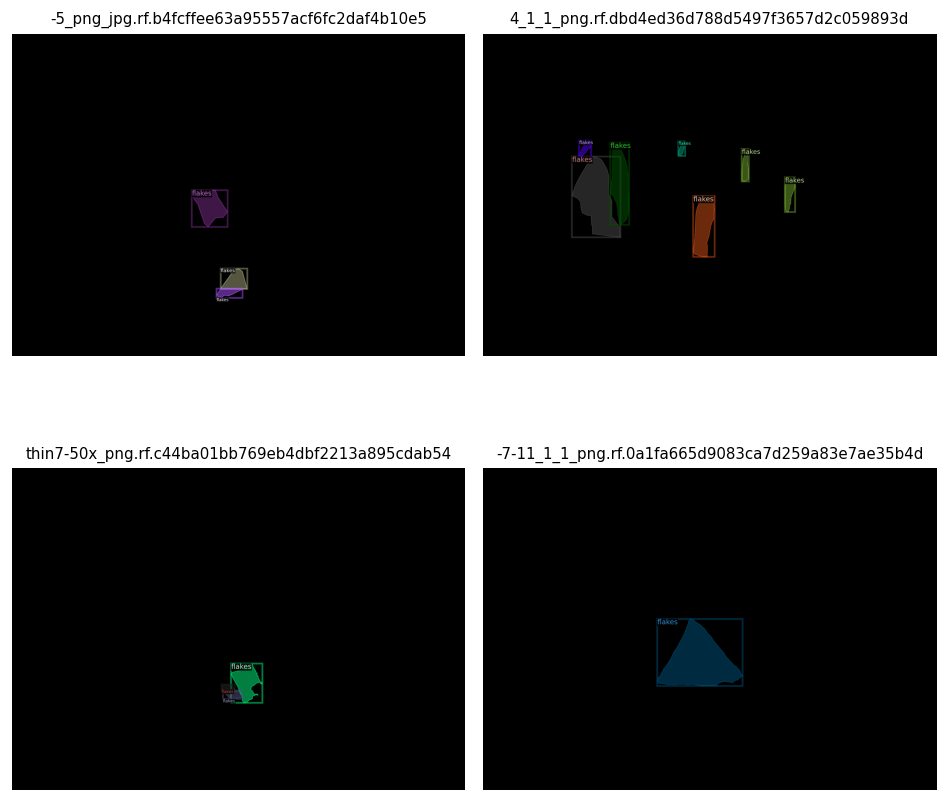

In [9]:
GRID_ROWS = 2
GRID_COLS = max(1, DISPLAY_COLUMNS)

def show_random_grid(rows: int = GRID_ROWS, cols: int = GRID_COLS):
    total = rows * cols
    picks = samples if len(samples) <= total else random.sample(samples, total)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = np.atleast_1d(axes).ravel()
    for ax, sample in zip(axes, picks):
        render_sample(sample, ax=ax)
        ax.set_title(Path(sample["file_name"]).stem, fontsize=9)
    for ax in axes[len(picks):]:
        ax.axis("off")
    fig.tight_layout()
    return fig

show_random_grid()
